Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________

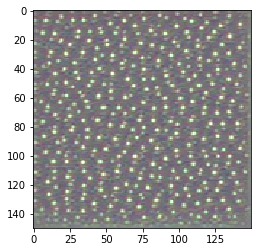

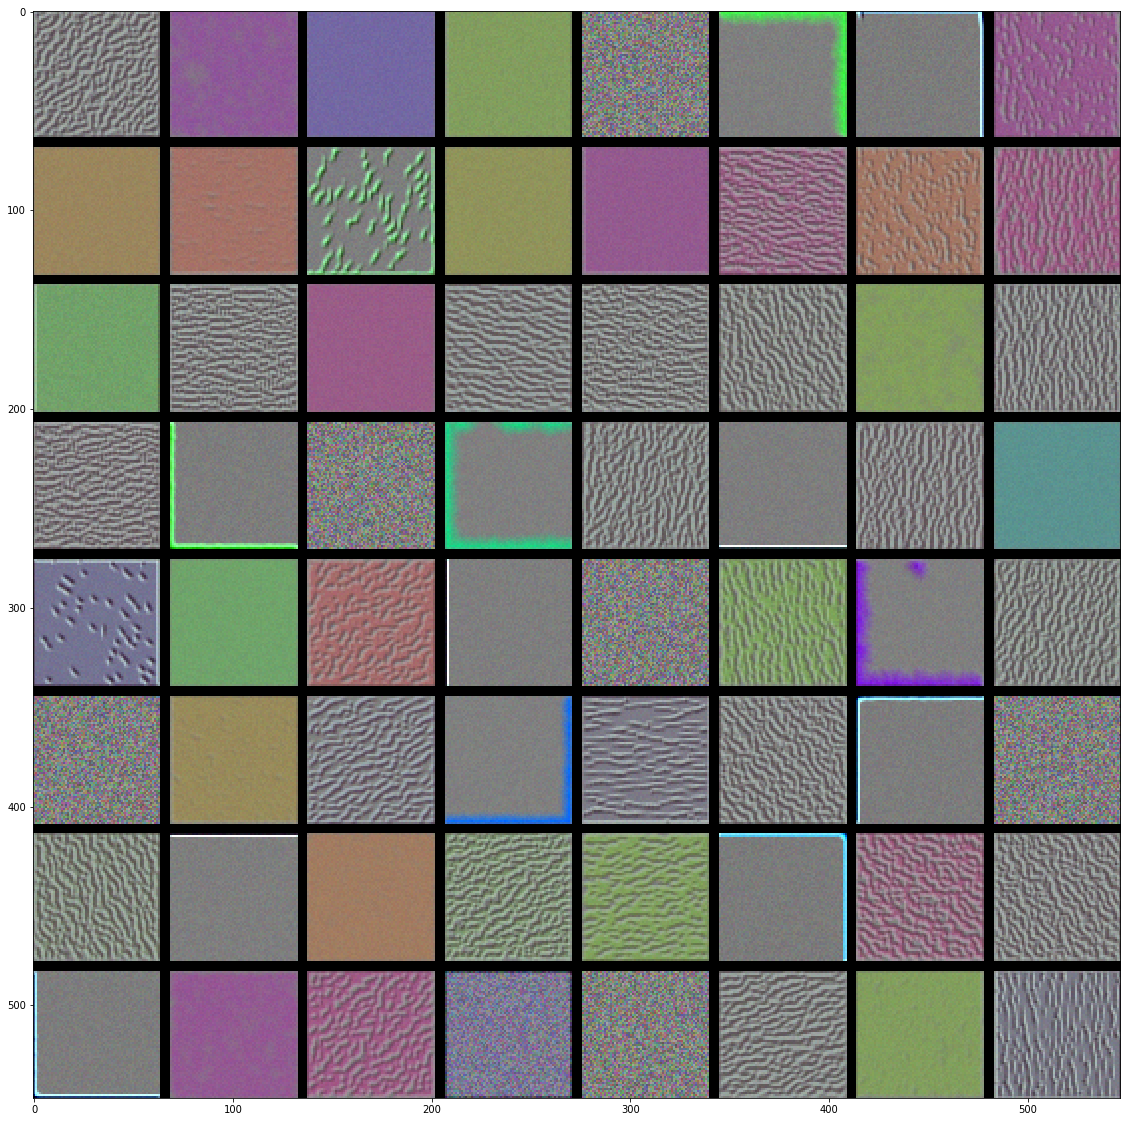

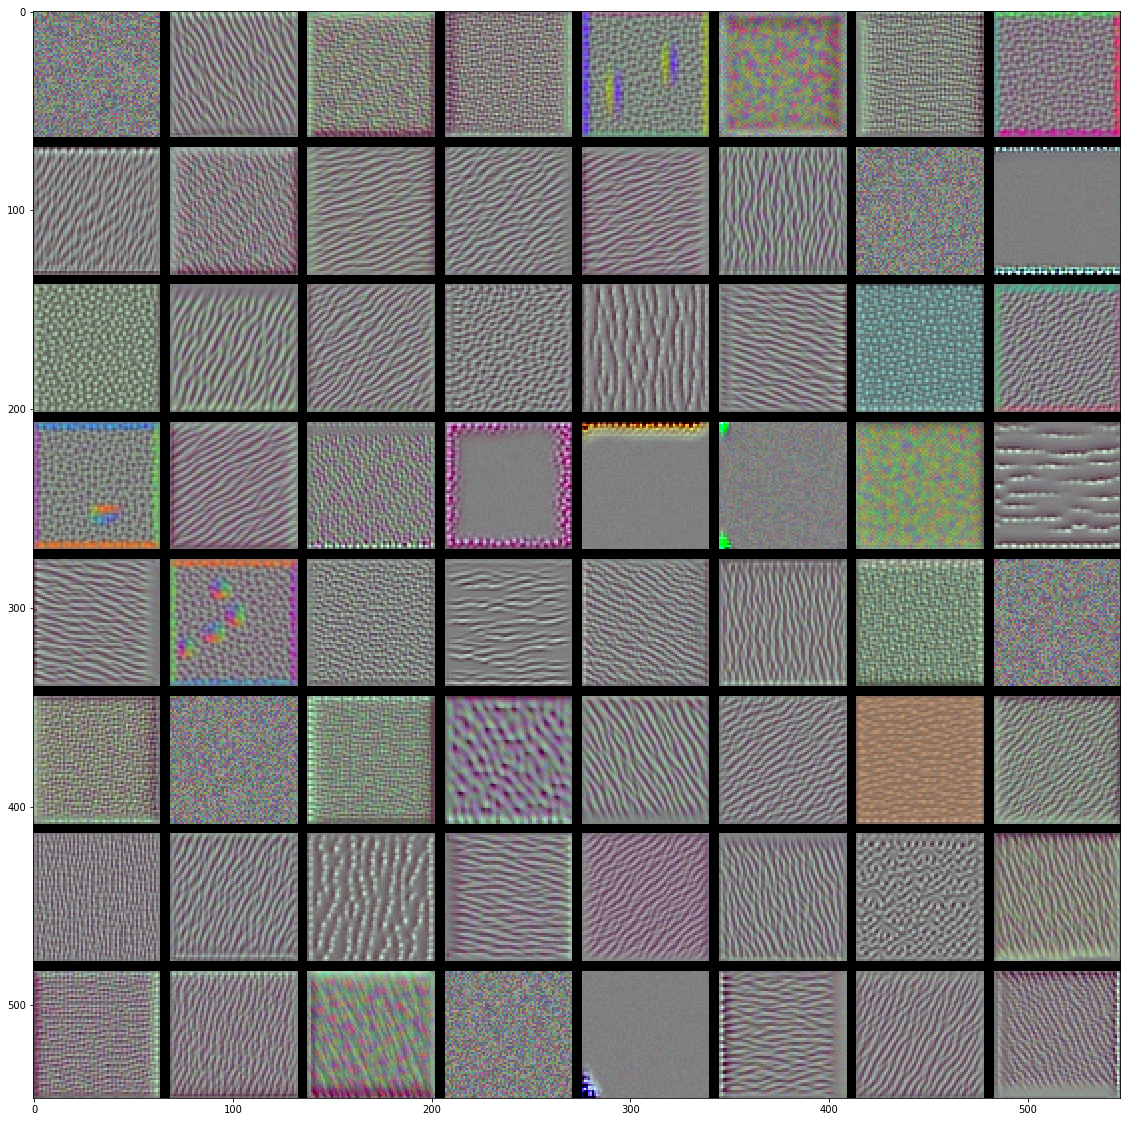

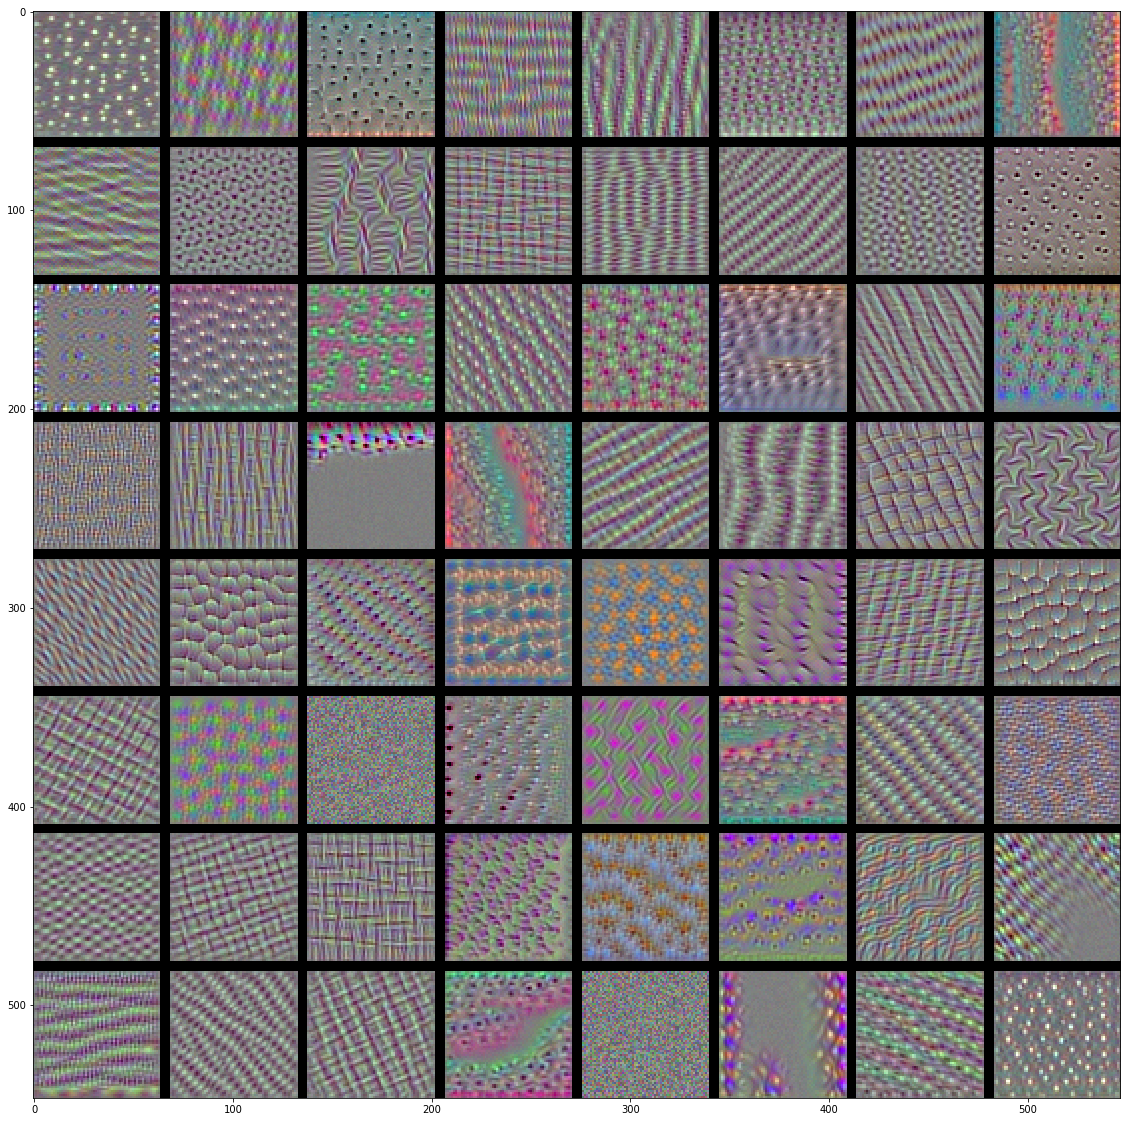

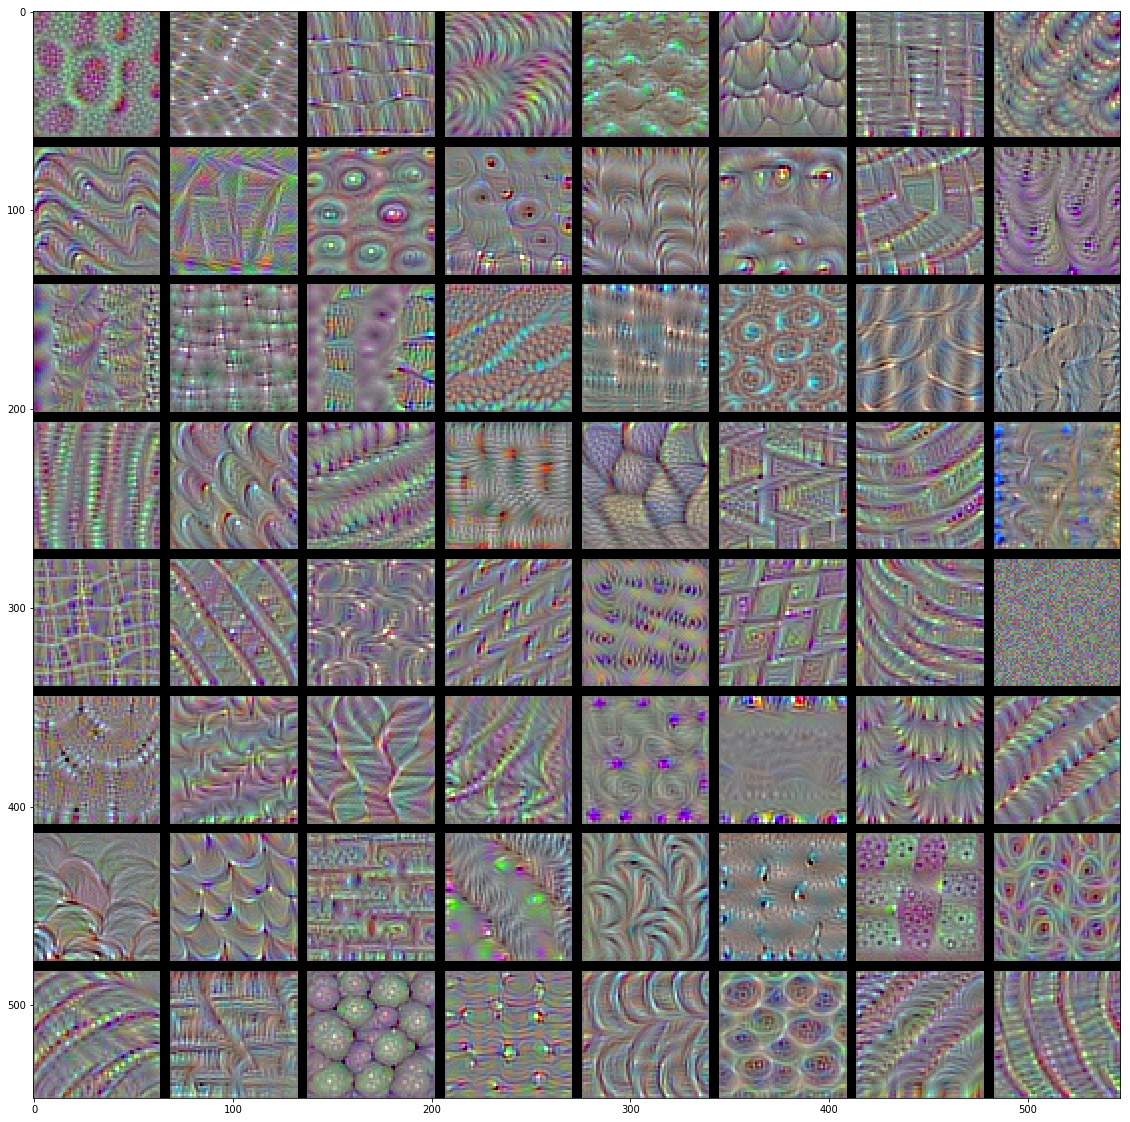

CPU times: user 1min 47s, sys: 3.13 s, total: 1min 50s
Wall time: 1min 41s


In [1]:
%%time
 # Basic  = 8:53
 # GPU with Colab = 2:35
 # Gpu 1080ti with old library = 4:07
 # GPU 1080ti with latest library = 1:34
 # TPU in Colab= 8:52

# 컨브넷 필터를 시각화하기
# 컨브넷의 필터가 찾으려는 시각적인 패턴과 개념이 무엇인지 상세하게 이해하는데 도움이 된다.
# 빈 입력 이미지에서 특정 필터의 응답을 최대화 하기 위해 이미지에 경사 상승법(손실 함수의 값이 커지는 방향으로 gradient update)
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
tf.compat.v1.disable_eager_execution()



# 필터 시각화를 위한 손실 텐서 정의
model = VGG16(weights = 'imagenet', include_top = False)
model.summary()


layer_name = 'block3_conv1'
filter_index = 0
size = 150


'''
경사 상승 과정을 부드럽게 하기 위해 그래디언트 텐서를 L2 Norm으로 나누어 정규화
이렇게 하면 입력 이미지에 적용할 수정량의 크기를 항상 일정 범위 안에 놓을 수 있다. - (Gradient Clipping)
L2 Norm으로 나눈 그래디언트의 L2 Norm은 1이 된다.
   
케라스의 keras.optimizers 모듈 아래에 있는 옵티마이저를 사용할 떄는 clipnorm과 clipvalue 매개변수를 설정하여 자동으로 그래디언트 클리핑을
수행할 수 있다. clipnorm 매개변수 값이 그래디언트의 L2 Norm보다 클 경우 각 그래디언트의 L2 Norm을 clipnorm 값으로 정규화.
clipvalue 매개변수를 지정하면 그래디언트의 최대 절댓값은 clipvalue 값이 된다. 두 매개변수를 모두 설정하면 clipnorm이 먼저 적용되고
clipvalue가 적용된다.

경사 상승법을 사용하기 때문에 keras.optimizers 모듈 아래에 있는 옵티마이저를 사용할 수 없고, 직접 학습 단계를 구현해야 한다.
keras.backend.function() 함수는 입력값을 받아 지정된 출력 텐서들을 얻을 수 있는 keras.backend.Function 객체를 만들어 준다.
'''

# (1, 150, 150, 3)크기의 부동 소수 텐서를 이미지 형태로 변환하기 위한 유틸리티 함수
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1  # 텐서의 평균이 0, 표준편차가 0.1이 되도록 정규화
    
    x += 0.5
    x = np.clip(x, 0, 1) # [0,1]로 클리핑
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8') # RGB로 변환
    return x


# 필터 시각화 이미지를 만드는 함수
def generate_pattern(layer_name, filter_index, size = size):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    # gradients 함수가 반환하는 텐서 리스트(여기에서 크기가 1인 리스트)에서 첫 번째 텐서를 추출

    # Gradient 정규화
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    # 입력 값에 대한 넘파이 출력 값 추출하기
    iterate = K.function([model.input], [loss, grads])
    # iterate는 넘파이 텐서(크기가 1인 텐서의 리스트)를 입력으로 받아 손실과 그래디언트 2개의 넘파이 텐서 반환
    
    # Stochastic 경사 상승법을 사용한 손실 최대화
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128. # 노이즈 섞인 회색 이미지로 시작.
    step = 1. # 업데이트 할 그래디언트의 크기
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data]) # 손실과 그래디언트 계산 (40번 실행)
        input_img_data += grads_value * step # 손실 최대화
        
    img = input_img_data[0]
    return deprocess_image(img)

plt.imshow(generate_pattern('block3_conv1', 0))

# 층에 있는 각 필터에 반응하는 패턴 생성하기
# ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
for layer_name2 in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5
    
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3), dtype = 'uint8') # 결과를 담을 빈(검은) 이미지
    for i in range(8): # results 그리드의 행을 반복
        for j in range(8): # results 그리드의 열을 반복
            filter_img = generate_pattern(layer_name2, i + (j * 8), size = size)
            
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
        
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
        
            results[horizontal_start : horizontal_end, vertical_start : vertical_end, :] = filter_img
        
    plt.figure(figsize = (20, 20))
    plt.imshow(results)
    plt.show()


In [2]:
tf.__version__

'2.2.0'

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1815996300537638067
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2633173064215667026
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10881024640
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 3106493368693228076
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:17:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 10858231232
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 1565561731245479041
physical_device_desc: "device: 1, name: GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 